In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from efficientnet_pytorch import EfficientNet

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [4]:
# load train and val dataframes
train_df = pd.read_csv("ENET_train_df.csv").sample(frac=.5)
val_df = pd.read_csv("ENET_val_df.csv")

n_train = train_df.shape[0]
n_val = val_df.shape[0]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_val))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

13610 Training and 3025 Validation samples
8.793 percent of validation data set is a positive.
Baseline validation accuracy is 91.207


In [5]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [6]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

'''
Training done in rounds, need different transforms in each round. 

round 1: Slight addition of noise + balanced training samples 
round 2: More noise + training sample balance matches test case

'''

# define a unique transform each time a positive is resampled: 

# define transform with more noise for round 2
transform_round_2 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.2), ratio=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
    
class RoundTwoDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_round_2(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]
    
class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [7]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [8]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=512, bias=True)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Linear(512, 1), 
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
model.load_state_dict(torch.load('../Models/ENETmodel.ckpt'))

<All keys matched successfully>

In [9]:
# Train the model
# Use the prebuilt data loader.
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"
path_to_model = '../Models/ENETmodel_round_2.ckpt'

# Set training params (batchsize limited by GPU memory)
num_epochs = 50
batchsize  = 25
min_balance = .25

# evaluate performance on unbalanced training data 
train_dataset = RoundTwoDataset(train_df, path)                                              
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batchsize) 

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset) 

# save losses from training 
train_roc = []
losses    = []

# save validation statistics 
val_roc = []
val_acc = []
val_precision = []
val_recall = []

patience     = 3
set_patience = 3 
best_val     = 0

# Loss and optimizer
criterion = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler reduces learning rate by factor of 10 when val auc does not improve
scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # set up model for training 
        model = model.train()
        
        images = images.to(device)
        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss
        losses.append(loss)
        
        if i%100 = 0:
            # Calculate ROC
            predictions = outputs.detach().cpu().numpy().ravel()
            targets = labels.cpu().numpy().ravel()

            fpr, tpr, _ = roc_curve(np.array(targets, np.int), np.array(predictions).ravel())
            train_roc_auc = auc(fpr, tpr)
            train_roc.append(train_roc_auc)

            # Calculate balance 
            balance = np.sum(targets) / len(targets)

            print ('Epoch [{}/{}], Step {}, Loss: {:.4f}, Train ROC AUC: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss.item(), train_roc_auc))
        
    # prep model for evaluation
    valid_predictions = []
    valid_targets = []
    model.eval() 
    with torch.no_grad():
        for j, (images, labels) in enumerate(valid_loader):
            images = images.to(device)

            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate val ROC
            valid_predictions += list(outputs.detach().cpu().numpy().ravel())
            valid_targets += list(labels.cpu().numpy().ravel()) 

    fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
    val_roc_epoch = auc(fpr, tpr)
    val_roc.append(val_roc_epoch)
    
    tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()
    val_acc_epoch = (tp + tn) / len(valid_targets)
    val_precision_epoch = tp / (tp + fp)
    val_recall_epoch = tp / (tp + fn)
    
    val_acc.append(val_acc_epoch)
    val_precision.append(val_precision_epoch)
    val_recall.append(val_recall_epoch)
    
    print ('\nEpoch [{}/{}], Val ROC AUC: {:.3f}, Val Acc: {:.3f}, Val Precision: {:.3f}, Val Recall {:.3f}\n'
           .format(epoch+1, num_epochs, val_roc_epoch, val_acc_epoch, val_precision_epoch, val_recall_epoch))
    
    # learning rate is reduced if val roc doesn't improve 
    scheduler.step(val_roc_epoch)
    
    if val_roc_epoch > best_val:
        best_val = val_roc_epoch
        patience = set_patience        
        torch.save(model.state_dict(), path_to_model)  
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
            model.load_state_dict(torch.load(path_to_model), strict=False)
            break

# Load best model 
model.load_state_dict(torch.load(path_to_model))


Epoch [1/50], Val ROC AUC: 0.863, Val Acc: 0.919, Val Precision: 0.652, Val Recall 0.162


Epoch [2/50], Val ROC AUC: 0.839, Val Acc: 0.918, Val Precision: 0.846, Val Recall 0.083

Epoch     2: reducing learning rate of group 0 to 1.0000e-04.

Epoch [3/50], Val ROC AUC: 0.881, Val Acc: 0.927, Val Precision: 0.696, Val Recall 0.301


Epoch [4/50], Val ROC AUC: 0.883, Val Acc: 0.925, Val Precision: 0.627, Val Recall 0.361


Epoch [5/50], Val ROC AUC: 0.890, Val Acc: 0.926, Val Precision: 0.612, Val Recall 0.432


Epoch [6/50], Val ROC AUC: 0.892, Val Acc: 0.929, Val Precision: 0.676, Val Recall 0.361


Epoch [7/50], Val ROC AUC: 0.892, Val Acc: 0.932, Val Precision: 0.690, Val Recall 0.402


Epoch [8/50], Val ROC AUC: 0.894, Val Acc: 0.931, Val Precision: 0.652, Val Recall 0.451


Epoch [9/50], Val ROC AUC: 0.894, Val Acc: 0.935, Val Precision: 0.752, Val Recall 0.387



KeyboardInterrupt: 

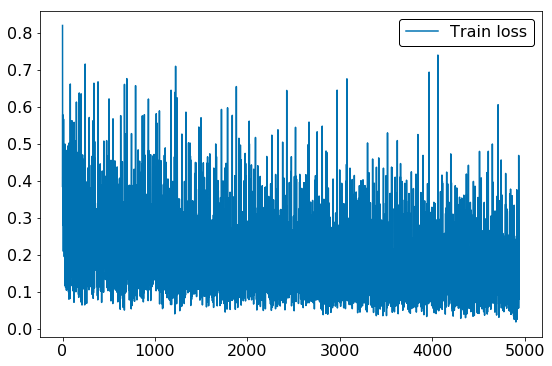

In [10]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

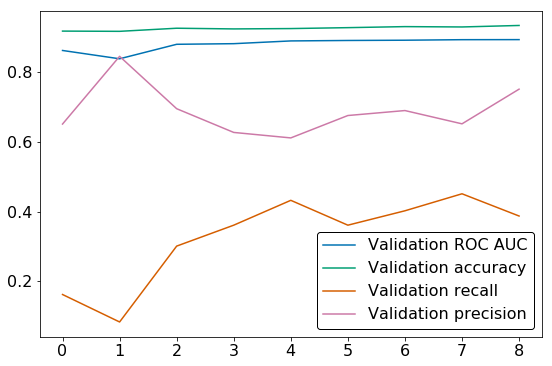

In [12]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(val_roc, label = 'Validation ROC AUC')
plt.plot(val_acc, label = 'Validation accuracy')
plt.plot(val_recall, label = 'Validation recall')
plt.plot(val_precision, label = 'Validation precision')
plt.plot()
plt.legend()
plt.show()


Baseline classification accuracy: 91.21

Model classification accuracy:    93.12


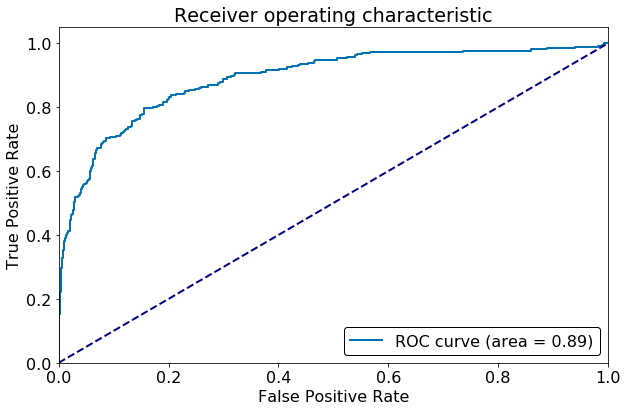

In [13]:
valid_predictions = []
valid_targets = []

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = 100 * np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [14]:
tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()

accuracy = (tp + tn) / len(valid_targets)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())))

Model accuracy: 0.93
Model precision: 0.67
Model recall: 0.42

Confusion Matrix: 
[[2704   55]
 [ 153  113]]


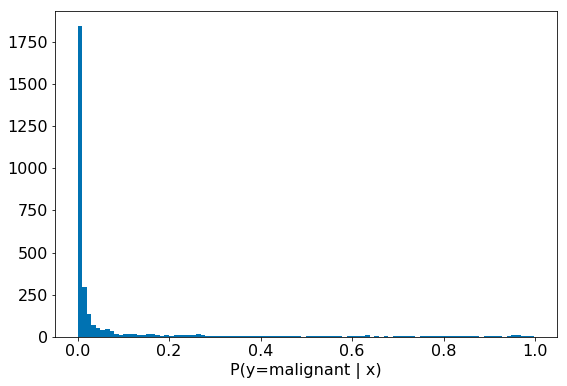

In [16]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(valid_predictions, bins=100)
plt.xlabel("P(y=malignant | x)")
plt.show()